## 0) Importing Libraries and Dataset

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:
# Importing the clean dataset

clean_credit_card_df = pd.read_csv('cleaned_credit_card_data.csv')

## 1) Data Preprocessing

The dataset contains many columns that useless for classificaton purposes, such as identifiers, names and other non-informative features that are only useful for human interpretation. We will remove these columns to reduce the dimensionality of the dataset and improve the performance of our model. In particular, we decided to drop the following columns:
- `ID`: unique identifier for each record
- `Name`: name of the individual
- `SSN`: social security number
- `Customer_ID`: unique identifier for each customer
- `Month`: month of the year in which the record was created


In [3]:
# Drop useless columns (identifiers, etc.)
columns_to_drop = ['ID', 'Customer_ID', 'Name', 'SSN', 'Month']
if columns_to_drop[0] in clean_credit_card_df.columns:
    clean_credit_card_df.drop(columns=columns_to_drop, inplace=True)

# Merge City and Street columns into a single Address column (at the start of the DataFrame)
if 'City' in clean_credit_card_df.columns and 'Street' in clean_credit_card_df.columns:
    clean_credit_card_df['Address'] = clean_credit_card_df['City'] + ', ' + clean_credit_card_df['Street']
    clean_credit_card_df.drop(columns=['City', 'Street'], inplace=True)
    address_column = clean_credit_card_df.pop('Address')
    clean_credit_card_df.insert(0, 'Address', address_column)

We also had to do some processing on the `Type_of_Loan` column, which contains a list of loan types. If we treated each different list as a differeent category, we would end up with a very large number of categories, which would make it difficult to train a model. Instead, we opted to identify all the possible values in the `Type_of_Loan` column and create a new column for each value, indicating how many of that type of loan the individual has.

In [4]:
# Store the unique values in the 'Type_of_Loan' column
loan_values = clean_credit_card_df['Type_of_Loan'].dropna().str.split(', ').explode().unique()
unique_loan_values = set()
for value in loan_values:
    value = value.replace('and ', '')
    unique_loan_values.add(value)


# Create new columns for each unique loan type
for loan_type in unique_loan_values:
    clean_credit_card_df[loan_type] = clean_credit_card_df['Type_of_Loan'].fillna('').str.count(loan_type)

loan_columns = list(unique_loan_values)
# For rows where Num_of_Loan == 0, set all loan columns to 0
clean_credit_card_df.loc[clean_credit_card_df['Num_of_Loan'] == 0, loan_columns] = 0

We can now check the consistency of the results by comparing the number of loans, stored in the `Num_of_Loan` column, with the sum of the new columns we created. If they are equal, we can be sure that our processing was correct.

In [5]:
# Check how many times the sum of each loan is not equal to number of loans
loan_columns += ['Num_of_Loan']
loan_df = clean_credit_card_df[loan_columns].copy()

# Sum the values in the loan columns and compare with Num_of_Loan
loan_df['Sum_of_Loans'] = loan_df[loan_columns[:-1]].sum(axis=1)

# Check for every 8 rows if the sum of loans is equal to Num_of_Loan
for i in range(0, len(loan_df), 8):
    subset = loan_df.iloc[i:i + 8]
    if not (subset['Sum_of_Loans'] == subset['Num_of_Loan']).all():
        print(f"Mismatch found in rows {i} to {i + 7}")

## 2) Data Visualization

Although we've completed some initial preprocessing, that was only a basic first step. Further preprocessing is necessary to prepare the data effectively for training a machine learning model. Data visualization plays a crucial role in this phase it helps us gain deeper insights into the data, spot potential issues, and uncover meaningful patterns or trends. For example, visualizing the distribution of the target variable or examining correlations between features and the target can guide our modeling decisions and improve performance.

### 2.1) Target Variable Distribution
We will start by visualizing the distribution of the target variable, `Credit_Score`, to understand its characteristics. This will help us determine if the data is balanced or imbalanced, which can influence our choice of evaluation metrics and modeling techniques. We will also check for any anomalies in the target variable that may need to be addressed.

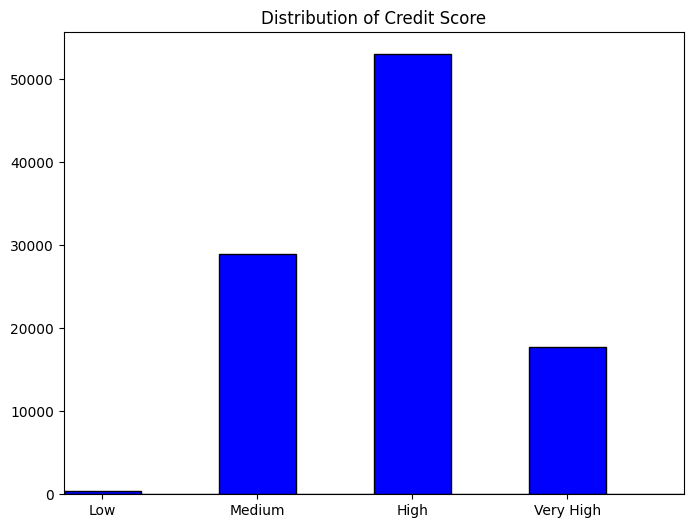

In [ ]:
# Show the distribution of the target variable with an histogram
bins = np.arange(0, 4.5, 0.5)

target_variable = clean_credit_card_df['Credit_Score']

plt.figure(figsize=(8, 6))
plt.hist(target_variable, bins=bins, color='blue', alpha=1.0, edgecolor='black')
plt.title('Distribution of Credit Score')
plt.xticks([0.25, 1.25, 2.25, 3.25], ['Low', 'Medium', 'High', 'Very High'])
plt.xlim(0, 4)
plt.show()

The bar chart above displays the distribution of the `Credit Score` target variable across four categories: **Low**, **Medium**, **High**, and **Very High**. From the visualization, it's clear that:
- The **High** category is the most frequent, indicating that the dataset is heavily skewed toward individuals with high credit scores.
- The **Medium** and **Very High** categories follow, with **Medium** having a considerably larger count.
- The **Low** category is extremely underrepresented, with very few instances.

This imbalance may lead to biased model predictions, as most algorithms assume an even distribution of classes. To address this, we will need to apply techniques to balance the dataset, such as oversampling the minority class or undersampling the majority class.

### 2.1) Numerical Features Distribution

We will now visualize the distribution of the numerical features in the dataset. This will help us understand the range and distribution of values for each feature, identify any potential outliers, and assess whether any transformations or scaling are needed before training our model.

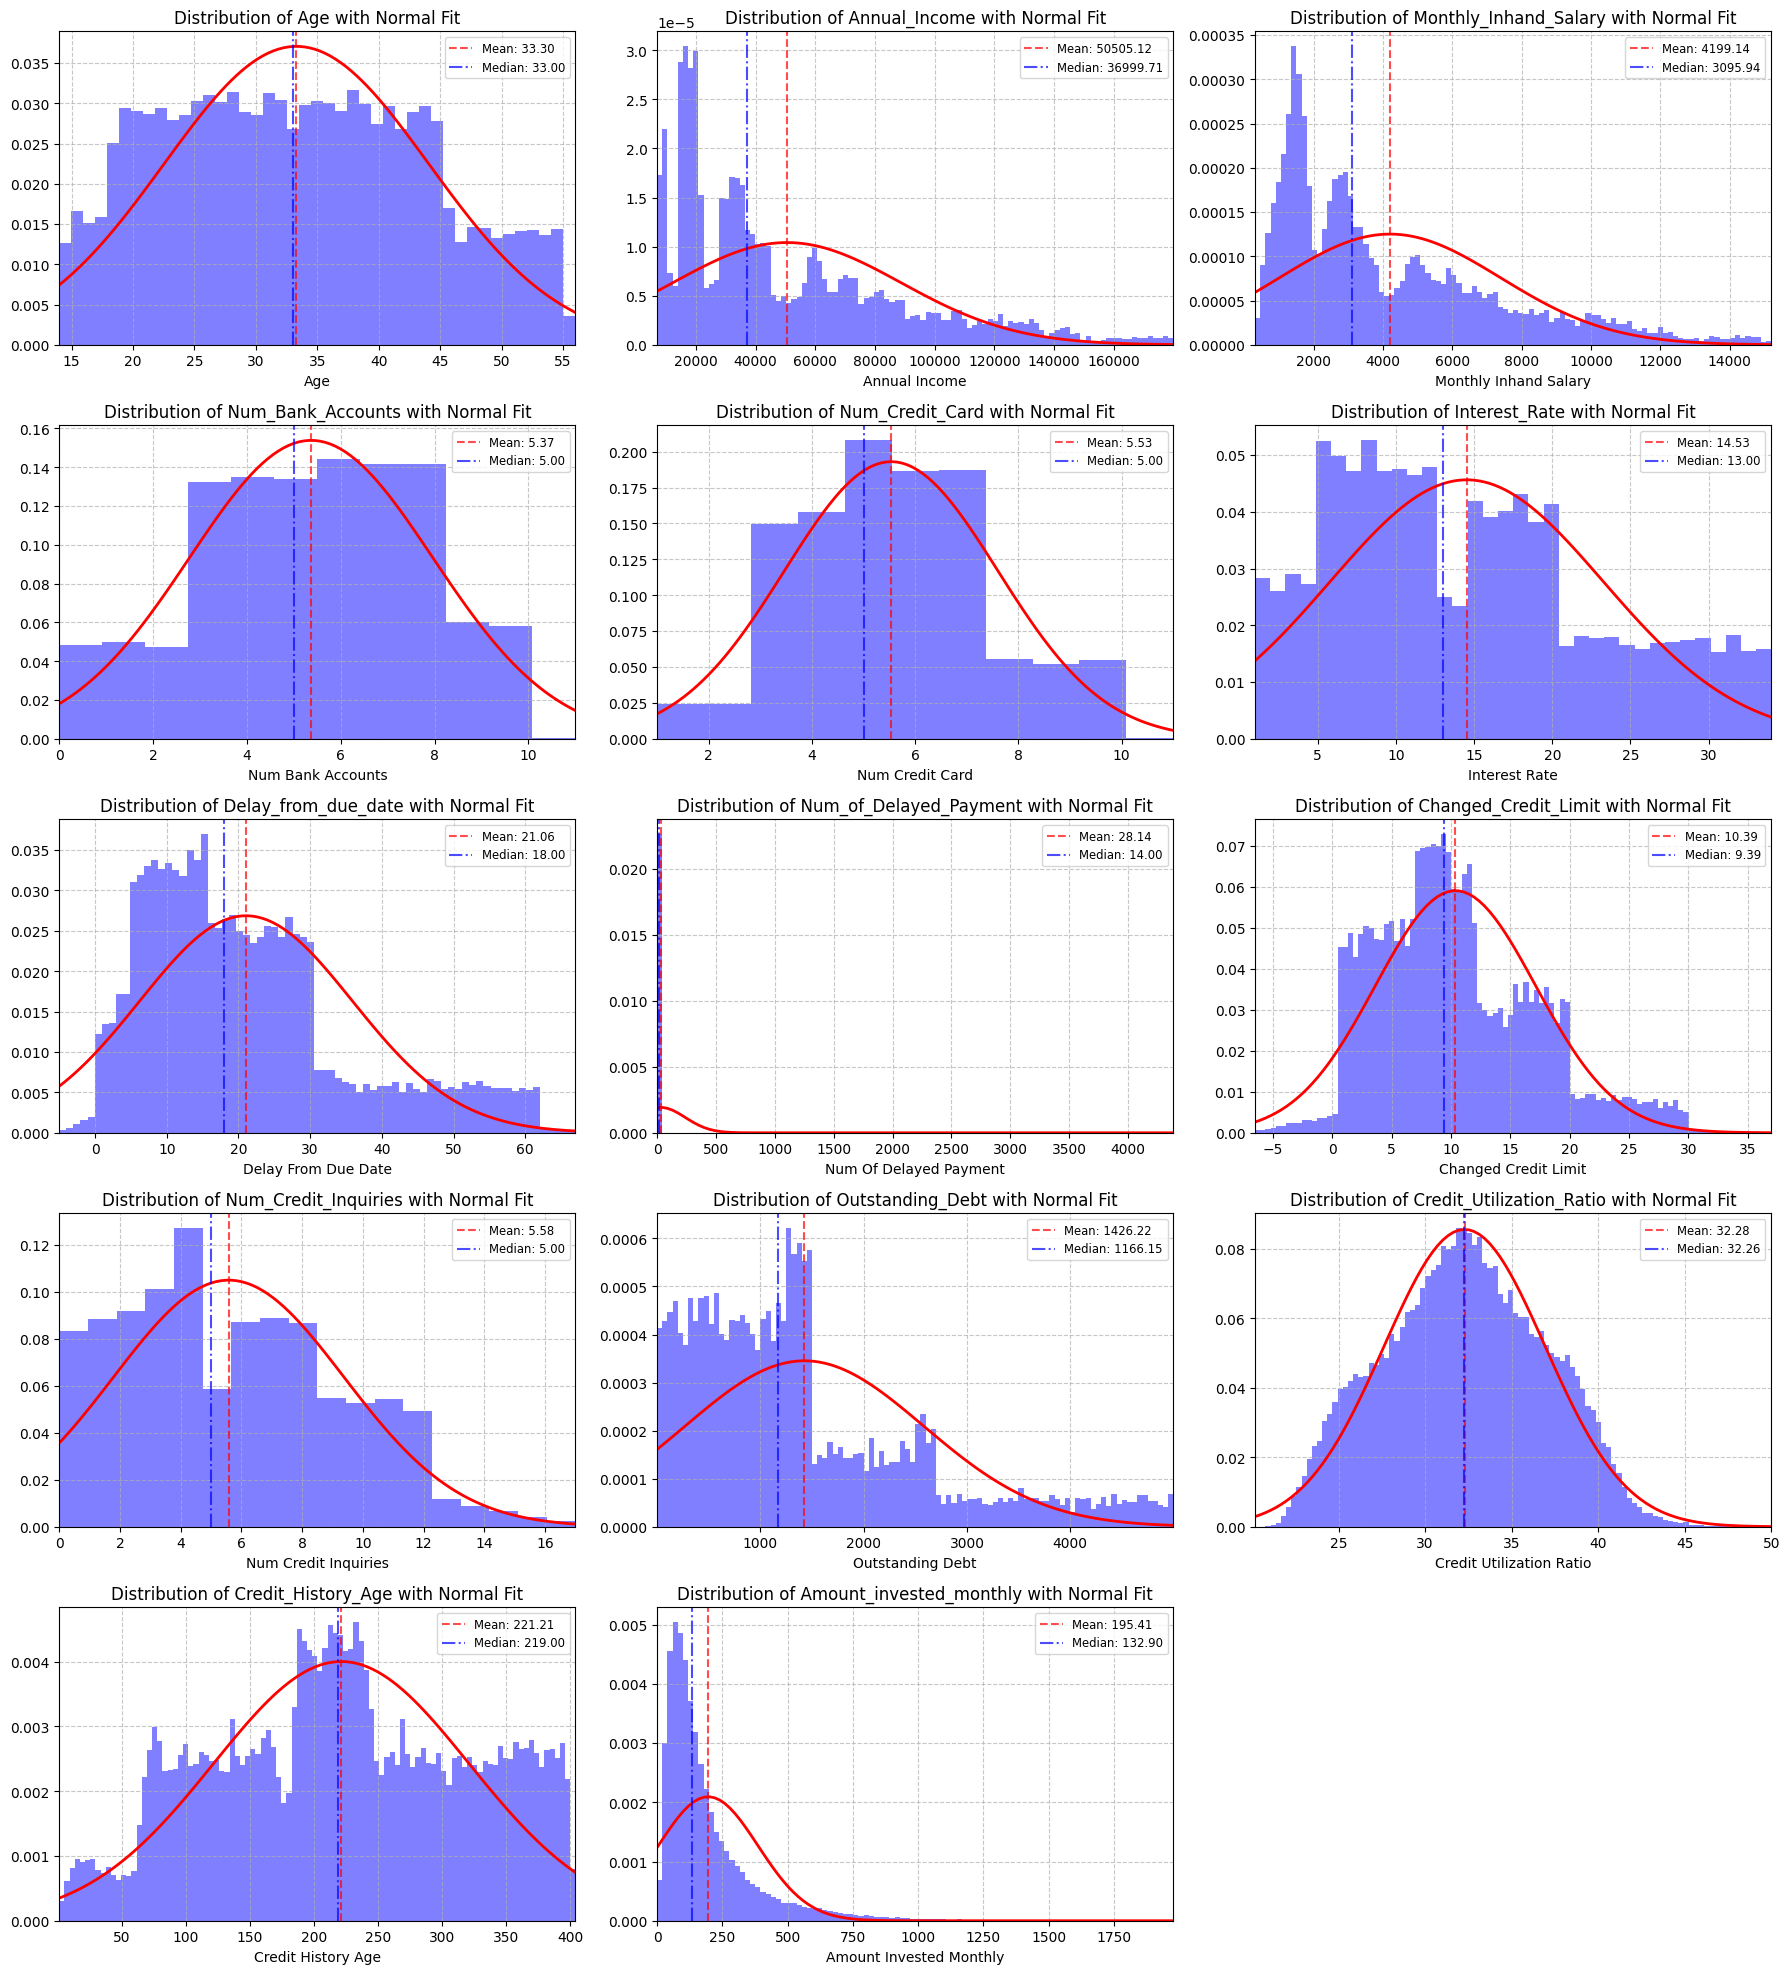

In [17]:
# Get the list of numerical feature names from the cleaned dataframe.
numeric_features = clean_credit_card_df.select_dtypes(include=['number']).columns
columns_to_drop = ['Credit_Score', 'Num_of_Loan'] + loan_columns
numeric_features = numeric_features.drop(columns_to_drop, errors='ignore')

n_features = len(numeric_features)

# Define grid size
n_cols = 3  # Number of columns in the grid
n_rows = (n_features + n_cols - 1) // n_cols  # Calculate required number of rows

# Create subplots with a grid layout
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows))
axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing

# Loop through all numerical features and plot their distributions
for i, col in enumerate(numeric_features):
    ax = axes[i]
    data = clean_credit_card_df[col]
    
    # Plot histogram with density normalization
    n_bins = 0
    ax.hist(data, bins = min(len(data.unique()), 100), density=True, alpha=0.5, color='blue')
    ax.set_xlim(data.min(), data.max())  # Set x-axis limits to focus on the range of interest
    
    # Fit a normal distribution to the data and plot it
    mu, std = norm.fit(data)
    x = np.linspace(data.min(), data.max(), 100)
    y = norm.pdf(x, mu, std)
    ax.plot(x, y, 'r-', lw=2)
    
    # Add vertical lines for mean and median
    mean_val = data.mean()
    median_val = data.median()
    ax.axvline(mean_val, color='red', linestyle='--', alpha=0.7, label=f'Mean: {mean_val:.2f}')
    ax.axvline(median_val, color='blue', linestyle='-.', alpha=0.7, label=f'Median: {median_val:.2f}')
    
    # Add legend, grid, and style ticks
    ax.legend(fontsize='small')
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.tick_params(axis='both', which='major', labelsize=10)
    
    # Set titles and labels
    ax.set_title(f'Distribution of {col} with Normal Fit')
    ax.set_xlabel(str(col).replace('_', ' ').title())

# Remove any unused subplots if n_features is not a multiple of n_cols
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

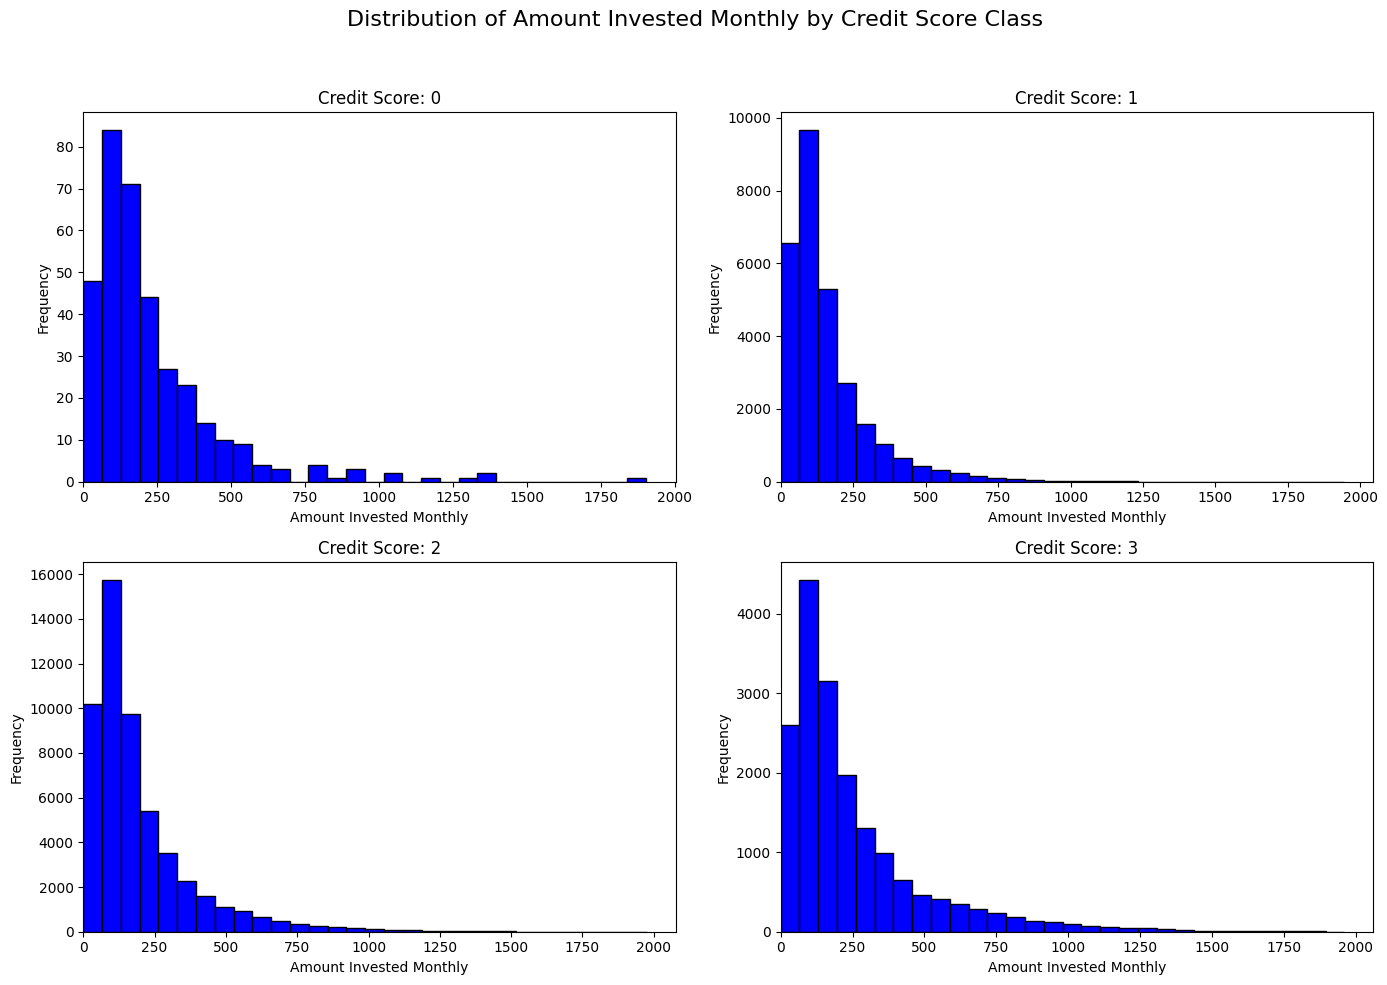

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Distribution of Amount Invested Monthly by Credit Score Class', fontsize=16)
axes = axes.flatten()

for i in range(4):
    subset = clean_credit_card_df[clean_credit_card_df['Credit_Score'] == i]['Amount_invested_monthly'].dropna()
    
    axes[i].hist(subset, bins=30, color='blue', edgecolor='black')
    axes[i].set_title(f'Credit Score: {i}')
    axes[i].set_xlabel('Amount Invested Monthly')
    axes[i].set_ylabel('Frequency')
    axes[i].set_xlim(0, subset.max() + 100)  # Optional: still okay to set xlim

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()



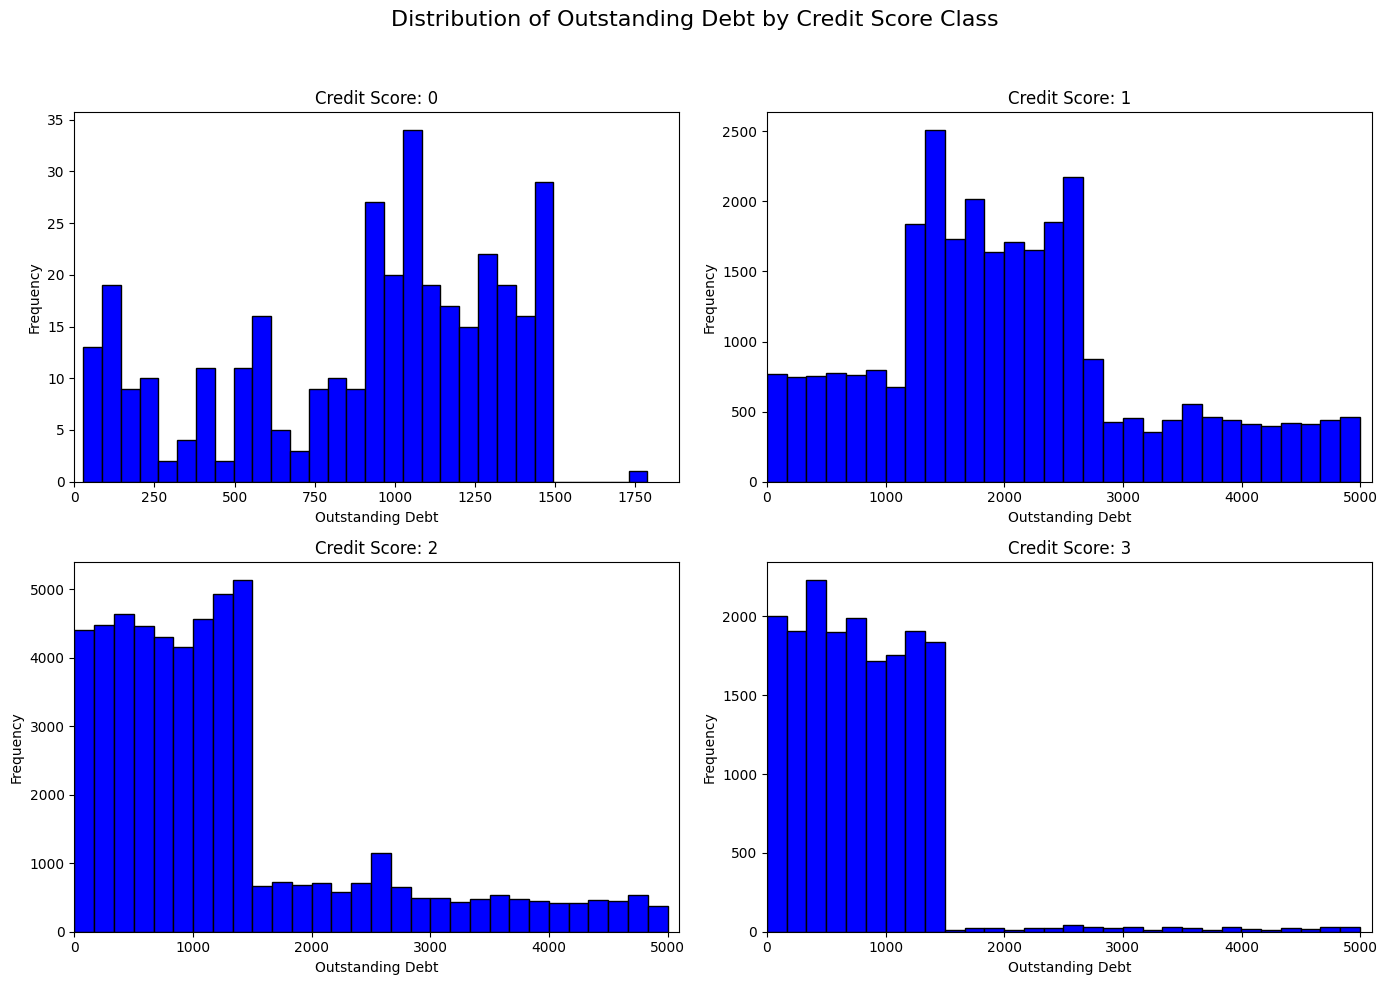

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Distribution of Outstanding Debt by Credit Score Class', fontsize=16)
axes = axes.flatten()

for i in range(4):
    subset = clean_credit_card_df[clean_credit_card_df['Credit_Score'] == i]['Outstanding_Debt'].dropna()
    
    axes[i].hist(subset, bins=30, color='blue', edgecolor='black')
    axes[i].set_title(f'Credit Score: {i}')
    axes[i].set_xlabel('Outstanding Debt')
    axes[i].set_ylabel('Frequency')
    axes[i].set_xlim(0, subset.max() + 100)  # Optional: still okay to set xlim

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

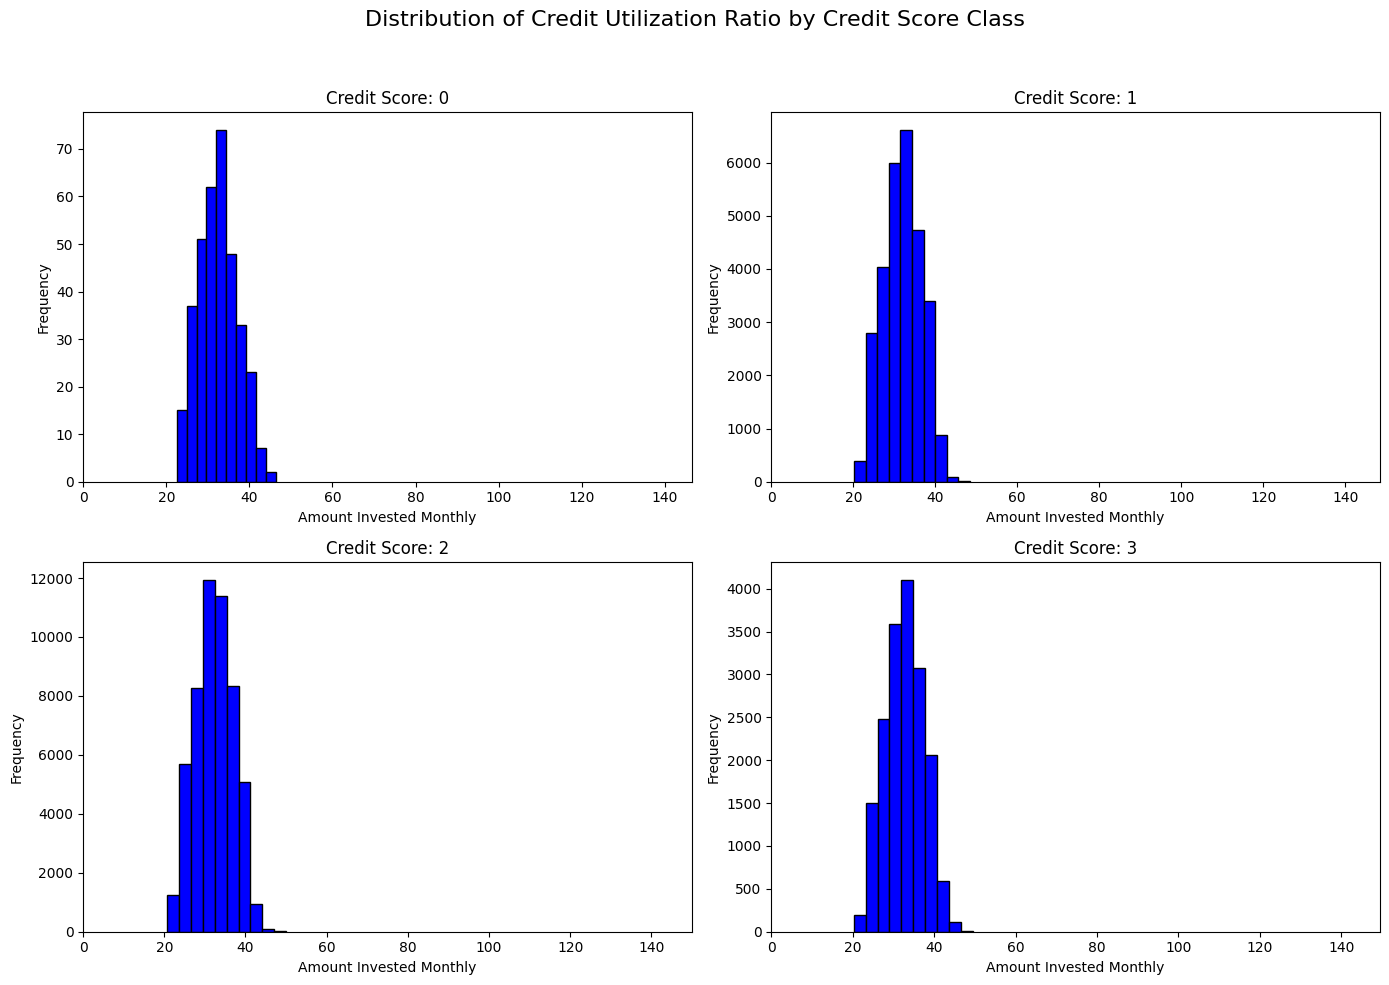

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Distribution of Credit Utilization Ratio by Credit Score Class', fontsize=16)
axes = axes.flatten()

for i in range(4):
    subset = clean_credit_card_df[clean_credit_card_df['Credit_Score'] == i]['Credit_Utilization_Ratio'].dropna()
    
    axes[i].hist(subset, bins=10, color='blue', edgecolor='black')
    axes[i].set_title(f'Credit Score: {i}')
    axes[i].set_xlabel('Amount Invested Monthly')
    axes[i].set_ylabel('Frequency')
    axes[i].set_xlim(0, subset.max() + 100)  # Optional: still okay to set xlim

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

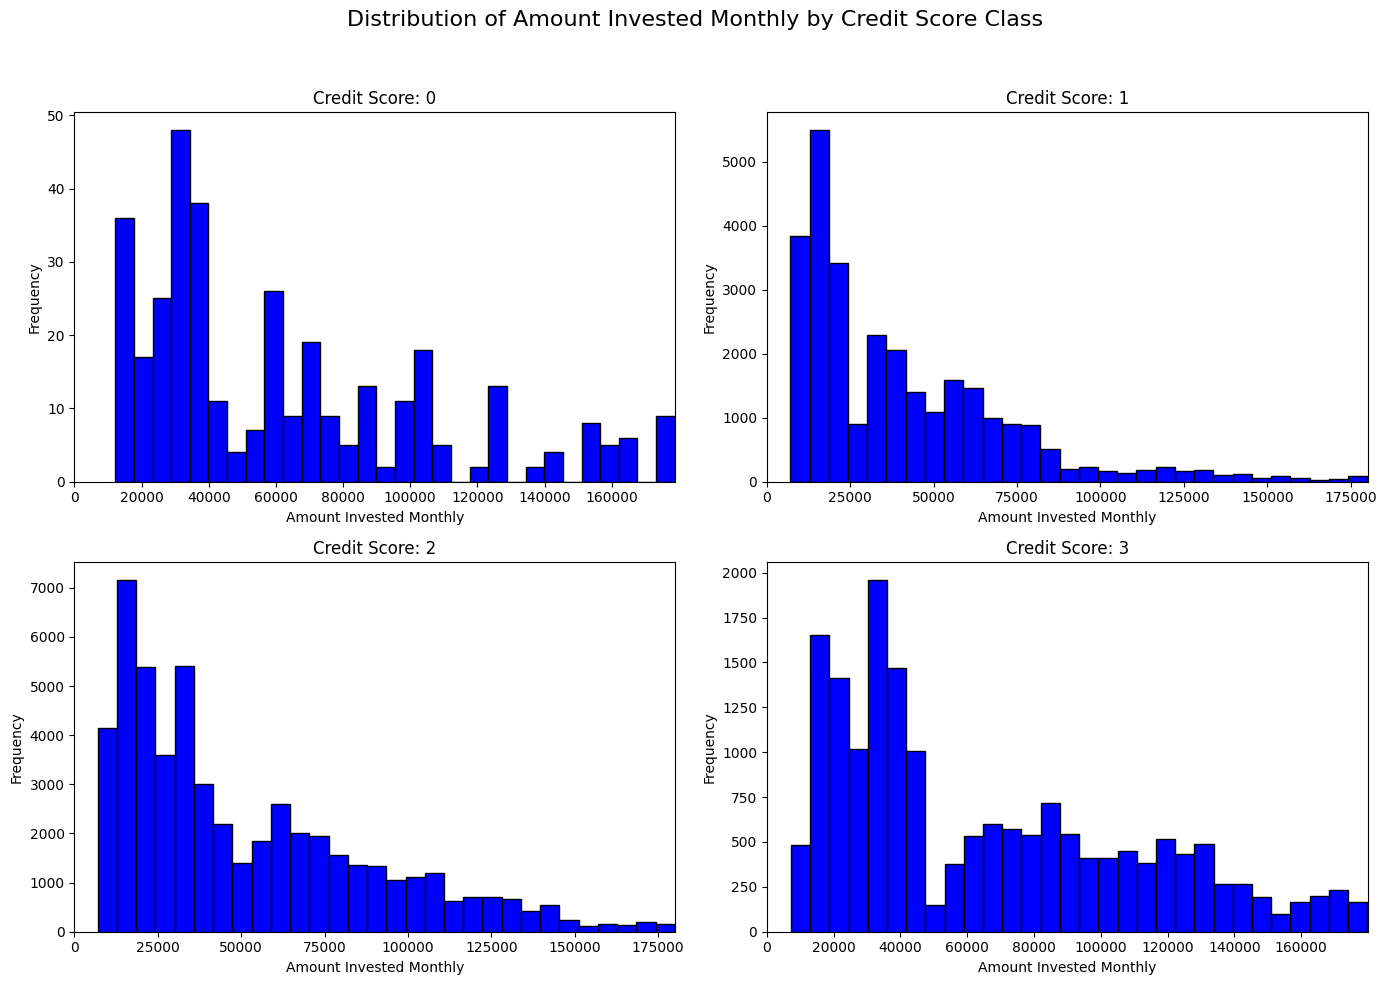

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Distribution of Amount Invested Monthly by Credit Score Class', fontsize=16)
axes = axes.flatten()

for i in range(4):
    subset = clean_credit_card_df[clean_credit_card_df['Credit_Score'] == i]['Annual_Income'].dropna()
    
    axes[i].hist(subset, bins=30, color='blue', edgecolor='black')
    axes[i].set_title(f'Credit Score: {i}')
    axes[i].set_xlabel('Amount Invested Monthly')
    axes[i].set_ylabel('Frequency')
    axes[i].set_xlim(0, subset.max() + 100)  # Optional: still okay to set xlim

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

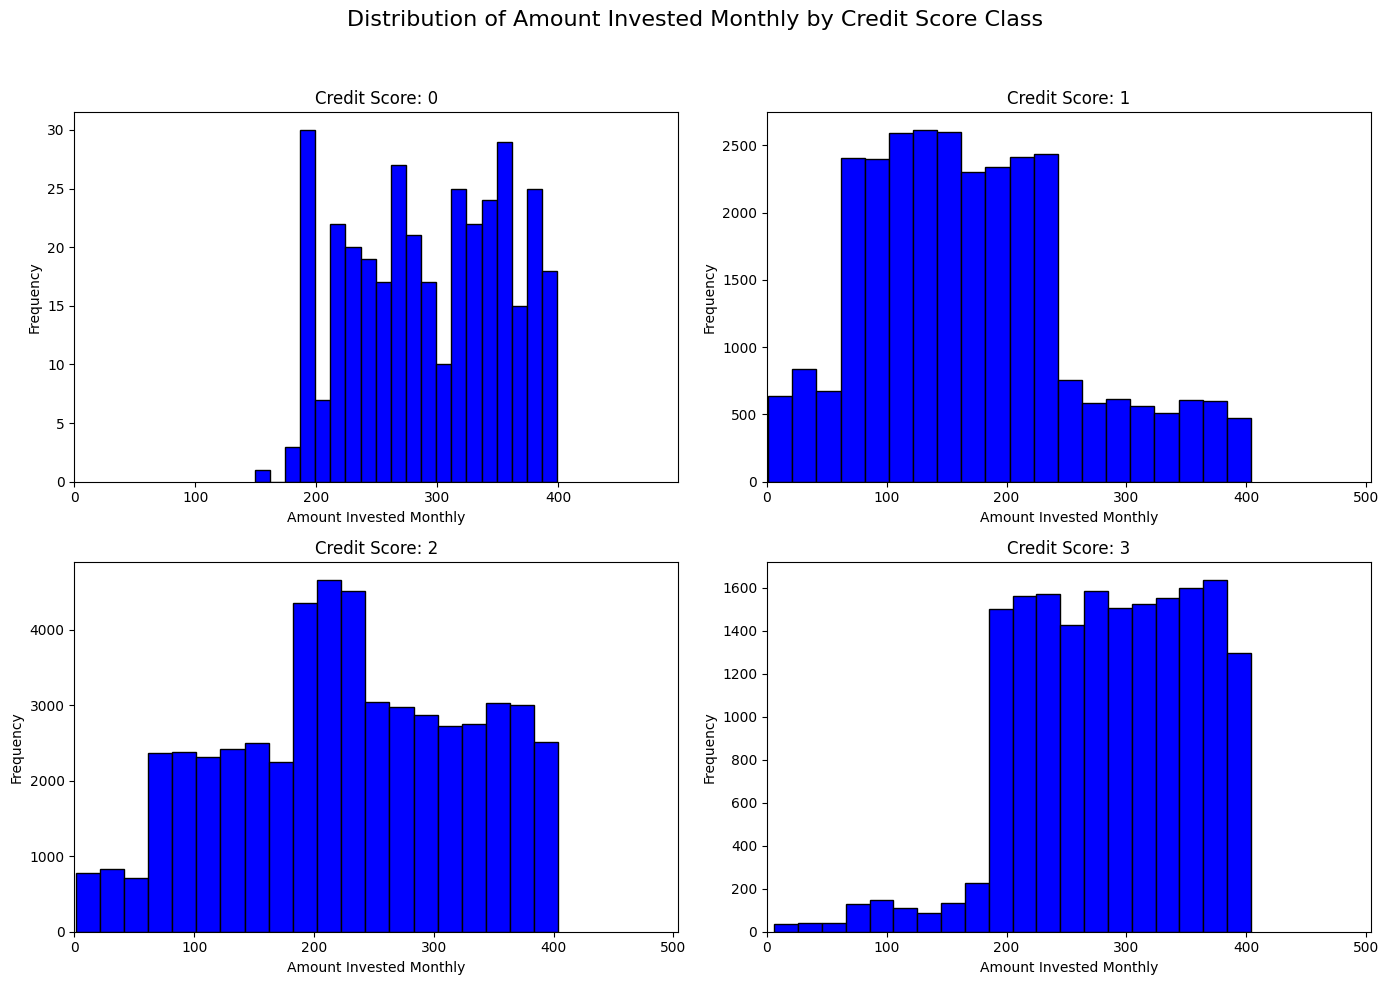

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Distribution of Amount Invested Monthly by Credit Score Class', fontsize=16)
axes = axes.flatten()

for i in range(4):
    subset = clean_credit_card_df[clean_credit_card_df['Credit_Score'] == i]['Credit_History_Age'].dropna()
    
    axes[i].hist(subset, bins=20, color='blue', edgecolor='black')
    axes[i].set_title(f'Credit Score: {i}')
    axes[i].set_xlabel('Amount Invested Monthly')
    axes[i].set_ylabel('Frequency')
    axes[i].set_xlim(0, subset.max() + 100)  # Optional: still okay to set xlim

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [10]:
# Store the cleaned dataset in a new CSV file
clean_credit_card_df.to_csv('cleaned_credit_card_data_final.csv', index=False)

In [ ]:
## Removing outliers from the dataset

def remove_outliers(df, column):
    """
    Remove outliers from a specified column in a DataFrame using the IQR method.
    
    Parameters:
      df: pandas DataFrame
      column: Column name from which to remove outliers
      
    Returns:
      A new DataFrame with outliers removed from the specified column.
    """
    
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 10 * IQR
    upper_bound = Q3 + 10 * IQR
    
    # Filter the DataFrame to remove outliers
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

print(f"Shape of the DataFrame before removing outliers: {credit_card_df.shape}")

# Loop through each numerical feature and remove outliers
for col in numerical_features:
    cleaned_credit_card_df = remove_outliers(cleaned_credit_card_df, col)

# Display the shape of the DataFrame after removing outliers
print(f"Shape of the DataFrame after removing outliers: {cleaned_credit_card_df.shape}")